# Deep Emulator in the Kato-Phillips Case: Postprocessing NN Outputs


We use the trained neural network to apply it to new unseen data. We convert the outputs back to readable data.
We apply the neural network several times in a row to build the trajectory again, from a given initial state.


#### Structure of the Notebook
1. Import Libraries and Initialize Data
2. Apply Model (Basic)
3. Apply Model (Roll-out)
4. Plot and Save

### 1. Import Libraries and Initialize Data

In [22]:
import os
import xarray as xr
import numpy as np
import jax.numpy as jnp
from flax.training.checkpoints import restore_checkpoint
from mlp import MLP
from tunax.space import Trajectory
from tunax import Grid
from sklearn.metrics import explained_variance_score

from typing import List, Tuple, TypeAlias
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]

from utils import preprocess_and_generate_labels, traj_from_ds

In [23]:
n_sim = 100 # metadata to handle (.yaml?)
norm_factor = 25.
depth = 50
grid = Grid.linear(depth, depth)

In [24]:
# Load state dict and initialize model
checkpoint_dir = os.path.abspath("checkpoints")
params = restore_checkpoint(checkpoint_dir, target=None)

# Initialize model
model = MLP(hidden_sizes=[64, 64]) # same layers as in training script

/home/durifa/Documents/deep_emulators/ige_deep_emulators/tunax_env/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [25]:
# Load data

data_dir = "data/"  # where simulations files are stored
file_names = [f"traj{i}.nc" for i in range(n_sim)]
file_paths = [os.path.join(data_dir, name) for name in file_names]

# Load application data
app_data = np.load("data/inf_combined_data.npy")
app_labels = np.load("data/inf_labels.npy")

#### 2. Apply Model (One Iteration)

In [26]:
app_predictions = model.apply(params, app_data)
app_score = explained_variance_score(app_labels, app_predictions)
app_score

-0.1625242978334427

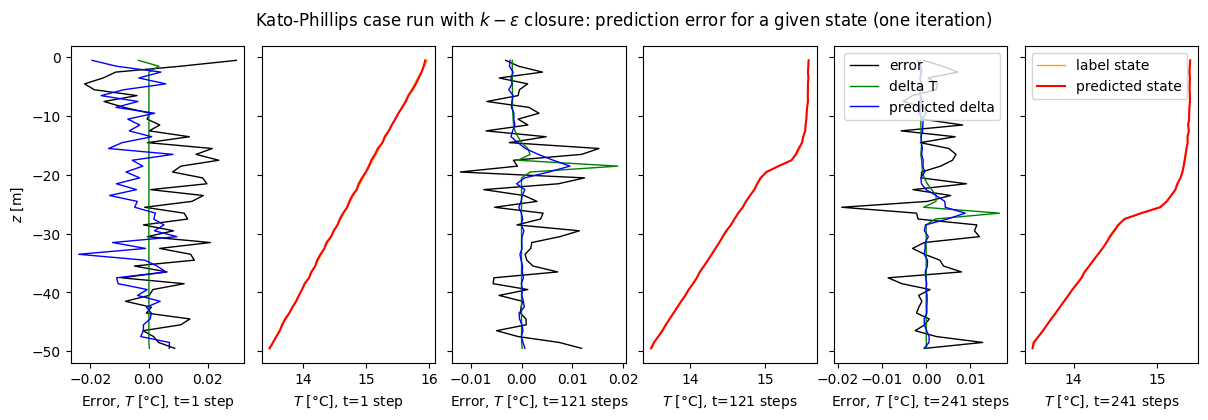

In [76]:
# Plot and compare to actual trajectory

sim_index = 2
t = 1 # better if <120
n_time = 359
actual_predictions = app_predictions*norm_factor
actual_labels = app_labels*norm_factor

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 6, sharey=True, figsize=(12, 4))
fig, [ax_r, ax_s, ax_t, ax_u, ax_v, ax_w] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_r.plot(actual_labels[sim_index*n_time+t, :]-actual_predictions[sim_index*n_time+t, :], zr, 'k', linewidth=1)
ax_r.plot(actual_labels[sim_index*n_time+t, :]-actual_labels[sim_index*n_time+t-1, :], zr, 'g', linewidth=1)
ax_r.plot(actual_predictions[sim_index*n_time+t, :]-actual_predictions[sim_index*n_time+t-1, :], zr, 'b', linewidth=1)
ax_s.plot(actual_labels[sim_index*n_time+t, :], zr, 'orange', linewidth=1)
ax_s.plot(actual_predictions[sim_index*n_time+t, :], zr, 'r')
ax_t.plot(actual_labels[sim_index*n_time+t+120, :]-actual_predictions[sim_index*n_time+t+120, :], zr, 'k', linewidth=1)
ax_t.plot(actual_labels[sim_index*n_time+t+120, :]-actual_labels[sim_index*n_time+t-1+120, :], zr, 'g', linewidth=1)
ax_t.plot(actual_predictions[sim_index*n_time+t+120, :]-actual_predictions[sim_index*n_time+t-1+120, :], zr, 'b', linewidth=1)
ax_u.plot(actual_labels[sim_index*n_time+t+120, :], zr, 'orange', linewidth=1)
ax_u.plot(actual_predictions[sim_index*n_time+t+120, :], zr, 'r')
ax_v.plot(actual_labels[sim_index*n_time+t+240, :]-actual_predictions[sim_index*n_time+t+240, :], zr, 'k', linewidth=1, label='error')
ax_v.plot(actual_labels[sim_index*n_time+t+240, :]-actual_labels[sim_index*n_time+t+240-1, :], zr, 'g', linewidth=1, label= "delta T")
ax_v.plot(actual_predictions[sim_index*n_time+t+240, :]-actual_predictions[sim_index*n_time+t+240-1, :], zr, 'b', linewidth=1, label= "predicted delta")
ax_w.plot(actual_labels[sim_index*n_time+t+240, :], zr, 'orange', linewidth=1, label='label state')
ax_w.plot(actual_predictions[sim_index*n_time+t+240, :], zr, 'r', label='predicted state')

ax_r.set_xlabel (f'Error, $T$ [°C], t={t} step')
ax_t.set_xlabel (f'Error, $T$ [°C], t={t+120} steps')
ax_v.set_xlabel (f'Error, $T$ [°C], t={t+240} steps')
ax_s.set_xlabel (f'$T$ [°C], t={t} step')
ax_u.set_xlabel (f'$T$ [°C], t={t+120} steps')
ax_w.set_xlabel (f'$T$ [°C], t={t+240} steps')
ax_r.set_ylabel(r'$z$ [m]')
fig.suptitle(r'Kato-Phillips case run with $k-\varepsilon$ closure: prediction error for a given state (one iteration)')
ax_w.legend(framealpha=.8)
ax_v.legend(framealpha=.8)

plt.show()

### 3. Apply Model as a Roll out

In [86]:
# to parallelize over trajectories

def roll_out_from_traj(file_paths, inf_combined_data, norm_factor, model, params, start_index=0):
    # Initialization
    inf_combined_data, inf_labels = preprocess_and_generate_labels(file_paths, norm_factor)
    n_sim = len(file_paths)
    n_time = inf_combined_data.shape[0]//n_sim
    depth = inf_combined_data.shape[2]
    grid = Grid.linear(depth, depth)
    
    original_traj = [None] * n_sim
    deep_traj = [None] * n_sim
    explained_variance = np.zeros((n_sim, n_time))
    mse = np.zeros((n_sim, n_time, depth))
    
    # Roll out
    for i in range(n_sim):
        
        # get original trajectory
        data = xr.open_dataset(file_paths[i])
        original_traj[i] = traj_from_ds(data, grid)
        
        # get preprocessed data for the trajectory
        pre_data = np.zeros((n_time+1, 5, depth)) # initial state + n_time following states
        pre_data[:-1] = inf_combined_data[i*n_time:(i+1)*n_time]
        inf_labels_i = inf_labels[i*n_time:(i+1)*n_time]
        # initial state
        state_t = pre_data[start_index:start_index+1] # ! change with reshape function
        
        
        for t in range(start_index, n_time):
            temp_delta = model.apply(params, state_t)
            # stop residuals pre_data[t+1, 0, :] = pre_data[t, 0, :] + temp_delta # roll out
            pre_data[t+1, 0, :] = temp_delta
            
            # track the explained variance and mse
            explained_variance[i, t] = explained_variance_score(inf_labels[i*n_time+t], temp_delta[0])
            mse[i, t, :] = np.square(temp_delta[0]-inf_labels[i*n_time+t])

            # no need to postprocess because temp_delta are normalized too
            state_t = pre_data[t+1:t+2] # to change with reshape
        # pre_data temperatures are results of the model
        
        # store ith deep trajectory
        deep_traj[i] = Trajectory(grid=grid, time=original_traj[i].time,
                                  u=original_traj[i].u, v=original_traj[i].v,
                                  t=pre_data[:,0,:]*norm_factor, s=original_traj[i].s)

    return original_traj, deep_traj, mse, explained_variance


In [95]:
n_traj = 10
original_traj, deep_traj, mse, explained_variance = roll_out_from_traj(file_paths[:n_traj], app_data, 25., model, params)
#original_traj, deep_traj, mse, explained_variance = roll_out_from_traj(file_paths[:n_traj], app_data, 25., model, params, start_index=30)
# 4 minutes 20 for 100 trajectories MLP(64,128,64)
# 3 min for MLP(64,64)

/home/durifa/Documents/deep_emulators/ige_deep_emulators/utils.py:35: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


In [ ]:
checkpoint_noise = os.path.abspath("checkpoints_noise")
params_noise = restore_checkpoint(checkpoint_noise, target=None)
_, deep_traj_noise, mse_noise, explained_variance_noise = roll_out_from_traj(file_paths[:n_traj], app_data, 25., model, params_noise)

/home/durifa/Documents/deep_emulators/ige_deep_emulators/tunax_env/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
/home/durifa/Documents/deep_emulators/ige_deep_emulators/utils.py:35: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


In [ ]:
checkpoint_reg = os.path.abspath("checkpoints_reg")
params_reg = restore_checkpoint(checkpoint_reg, target=None)
_, deep_traj_reg, mse_reg, explained_variance_reg = roll_out_from_traj(file_paths[:n_traj], app_data, 25., model, params_reg)

/home/durifa/Documents/deep_emulators/ige_deep_emulators/tunax_env/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
/home/durifa/Documents/deep_emulators/ige_deep_emulators/utils.py:35: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


#### 4. Plots

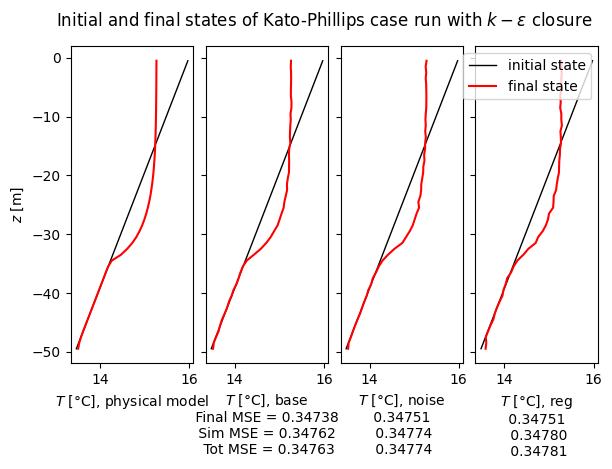

In [96]:
# Plot and compare to actual trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]
traj_deep_noise = deep_traj_noise[sim_index]
traj_deep_reg = deep_traj_reg[sim_index]

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 4, sharey=True, figsize=(6, 4))
fig, [ax_t, ax_u, ax_v, ax_y] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[-1, :], zr, 'r')
ax_u.plot(traj_deep.t[0, :], zr, 'k', linewidth=1)
ax_u.plot(traj_deep.t[-1, :], zr, 'r')
ax_v.plot(traj_deep_noise.t[0, :], zr, 'k', linewidth=1)
ax_v.plot(traj_deep_noise.t[-1, :], zr, 'r')
ax_y.plot(traj_deep_reg.t[0, :], zr, 'k', linewidth=1, label='initial state')
ax_y.plot(traj_deep_reg.t[-1, :], zr, 'r', label='final state')

ax_t.set_xlabel ('$T$ [°C], physical model')
ax_u.set_xlabel (f'$T$ [°C], base \n Final MSE = {np.mean(mse[sim_index, -1]):.5f} \n Sim MSE = {np.mean(mse[sim_index]):.5f} \n Tot MSE = {np.mean(mse):.5f}')
ax_v.set_xlabel (f'$T$ [°C], noise \n {np.mean(mse_noise[sim_index, -1]):.5f} \n {np.mean(mse_noise[sim_index]):.5f}\n {np.mean(mse_noise):.5f}')
ax_y.set_xlabel(f'$T$ [°C], reg \n {np.mean(mse_reg[sim_index, -1]):.5f} \n {np.mean(mse_reg[sim_index]):.5f}\n {np.mean(mse_reg):.5f}')
ax_t.set_ylabel(r'$z$ [m]')
fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
ax_y.legend(framealpha=.8)

plt.show()

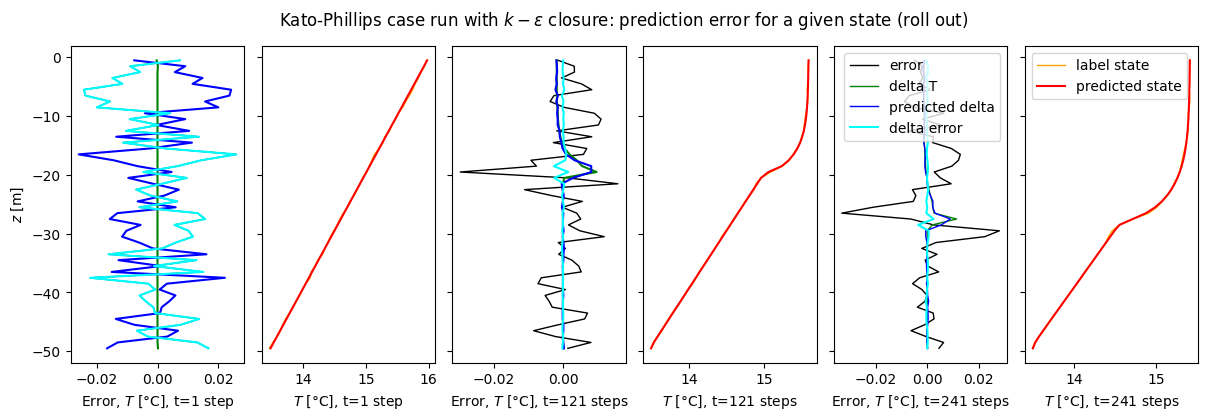

In [97]:
# Visualize the error and residuals

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]
t = 1 # t>0

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 6, sharey=True, figsize=(12, 4))
fig, [ax_r, ax_s, ax_t, ax_u, ax_v, ax_w] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_r.plot(traj_obs.t[t, :]-traj_deep.t[t, :], zr, 'k', linewidth=1)
ax_r.plot(traj_obs.t[t, :]-traj_obs.t[t-1, :], zr, 'g')
ax_r.plot(traj_deep.t[t, :]-traj_deep.t[t-1, :], zr, 'b')
ax_r.plot(traj_obs.t[t, :]-traj_obs.t[t-1, :] - (traj_deep.t[t, :]-traj_deep.t[t-1, :]), zr, 'cyan')
ax_s.plot(traj_deep.t[t, :], zr, 'orange', linewidth=1)
ax_s.plot(traj_obs.t[t, :], zr, 'r')

ax_t.plot(traj_obs.t[t+120, :]-traj_deep.t[t+120, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[t+120, :]-traj_obs.t[t-1+120, :], zr, 'g')
ax_t.plot(traj_deep.t[t+120, :]-traj_deep.t[t-1+120, :], zr, 'b')
ax_t.plot(traj_obs.t[t+120, :]-traj_obs.t[t-1+120, :] - (traj_deep.t[t+120, :]-traj_deep.t[t-1+120, :]), zr, 'cyan')
ax_u.plot(traj_deep.t[t+120, :], zr, 'orange', linewidth=1)
ax_u.plot(traj_obs.t[t+120, :], zr, 'r')

ax_v.plot(traj_obs.t[t+240, :]-traj_deep.t[t+240, :], zr, 'k', linewidth=1, label='error')
ax_v.plot(traj_obs.t[t+240, :]-traj_obs.t[t-1+240, :], zr, 'g', linewidth=1, label= "delta T")
ax_v.plot(traj_deep.t[t+240, :]-traj_deep.t[t-1+240, :], zr, 'b', linewidth=1, label= "predicted delta")
ax_v.plot(traj_obs.t[t+240, :]-traj_obs.t[t-1+240, :] - (traj_deep.t[t+240, :]-traj_deep.t[t-1+240, :]), zr, 'cyan', label= "delta error")
ax_w.plot(traj_deep.t[t+240, :], zr, 'orange', linewidth=1, label='label state')
ax_w.plot(traj_obs.t[t+240, :], zr, 'r', label='predicted state')

ax_r.set_xlabel (f'Error, $T$ [°C], t={t} step')
ax_t.set_xlabel (f'Error, $T$ [°C], t={t+120} steps')
ax_v.set_xlabel (f'Error, $T$ [°C], t={t+240} steps')
ax_s.set_xlabel (f'$T$ [°C], t={t} step')
ax_u.set_xlabel (f'$T$ [°C], t={t+120} steps')
ax_w.set_xlabel (f'$T$ [°C], t={t+240} steps')
ax_r.set_ylabel(r'$z$ [m]')
fig.suptitle(r'Kato-Phillips case run with $k-\varepsilon$ closure: prediction error for a given state (roll out)')
ax_w.legend(framealpha=.8)
ax_v.legend(framealpha=.8, loc='upper right')

plt.show()

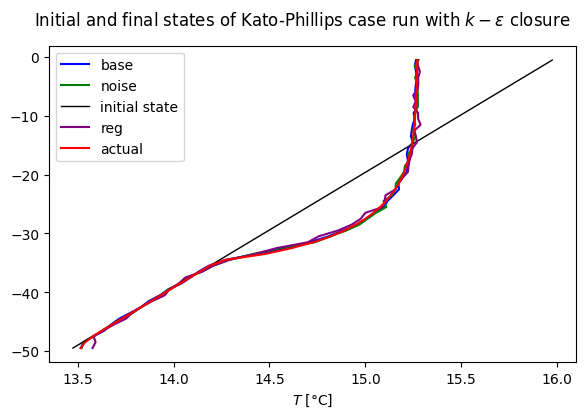

In [39]:
# Plot and compare to actual trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]
traj_deep_noise = deep_traj_noise[sim_index]
traj_deep_reg = deep_traj_reg[sim_index]

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig, ax_y = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_y.plot(traj_deep.t[-1, :], zr, 'b', label='base')
ax_y.plot(traj_deep_noise.t[-1, :], zr, 'g', label='noise')
ax_y.plot(traj_obs.t[0, :], zr, 'k', linewidth=1, label='initial state')
ax_y.plot(traj_deep_reg.t[-1, :], zr, 'purple', label='reg')
ax_y.plot(traj_obs.t[-1, :], zr, 'r', label='actual')

ax_y.set_xlabel('$T$ [°C]')
fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
ax_y.legend(framealpha=.8)

plt.show()

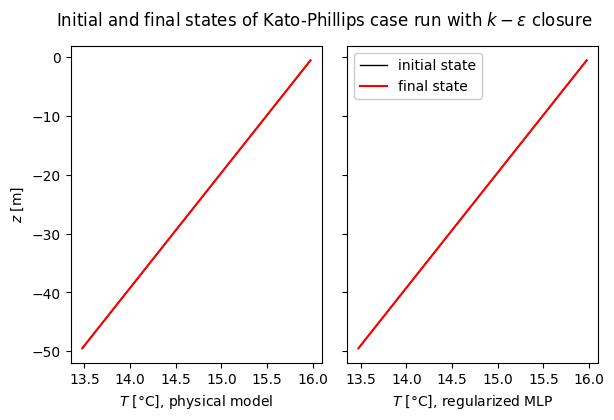

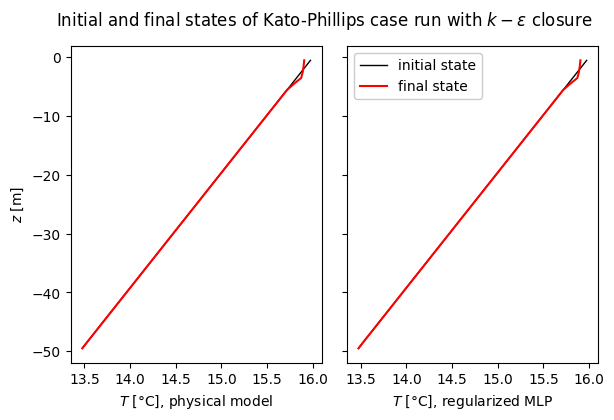

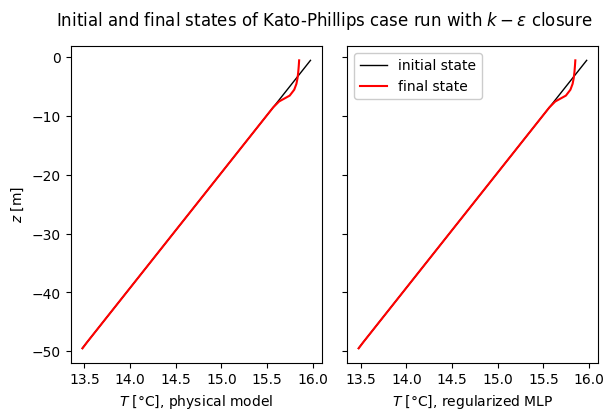

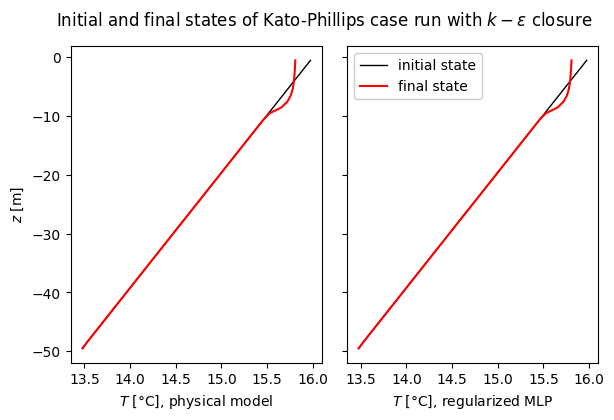

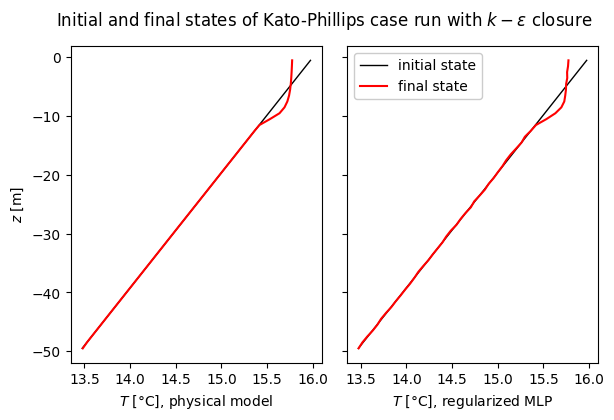

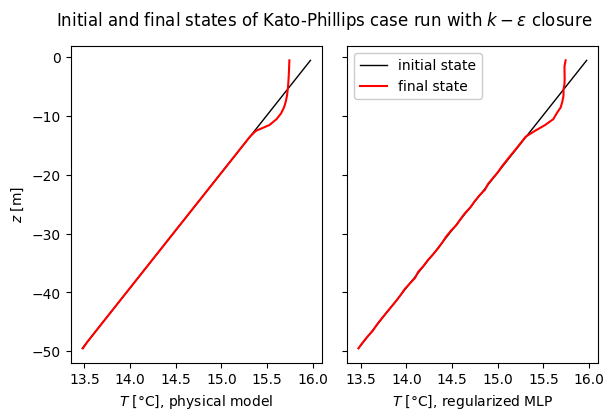

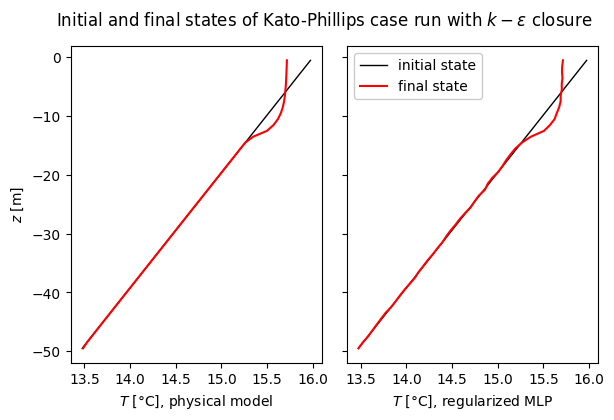

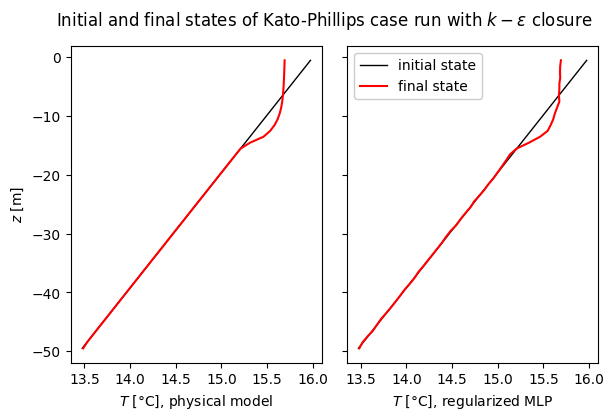

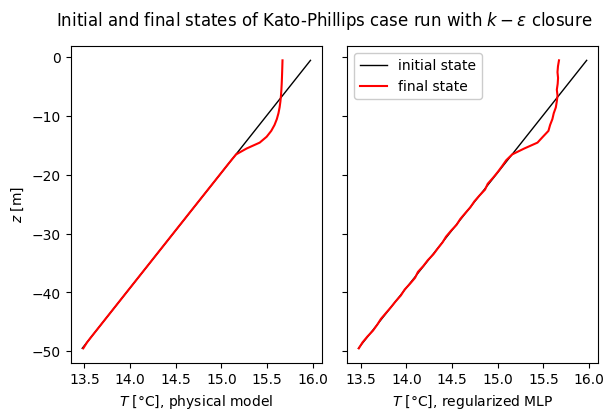

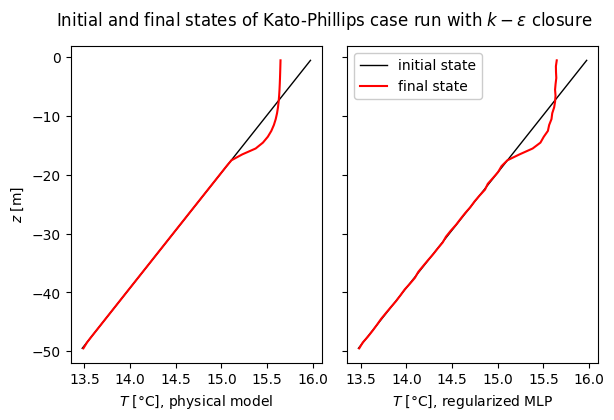

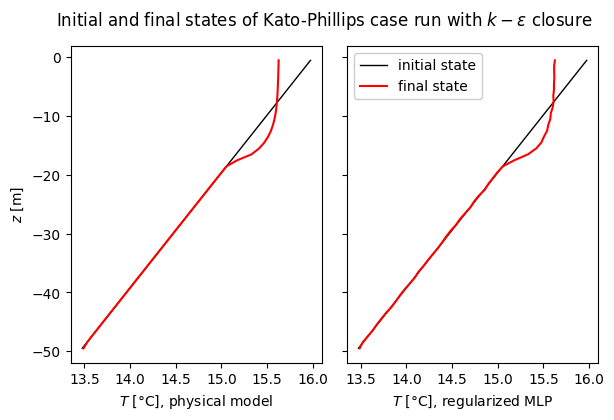

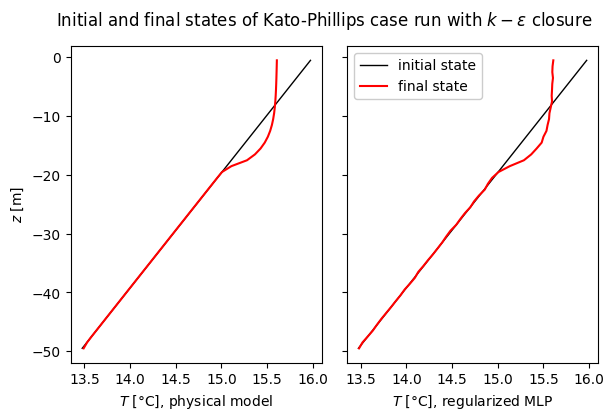

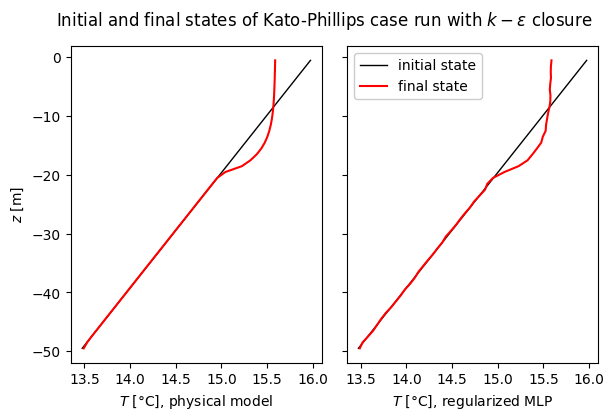

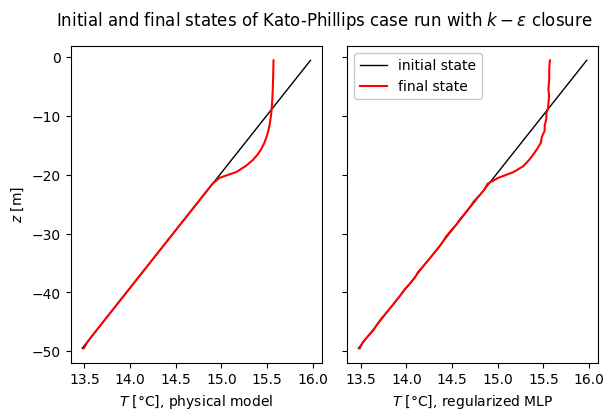

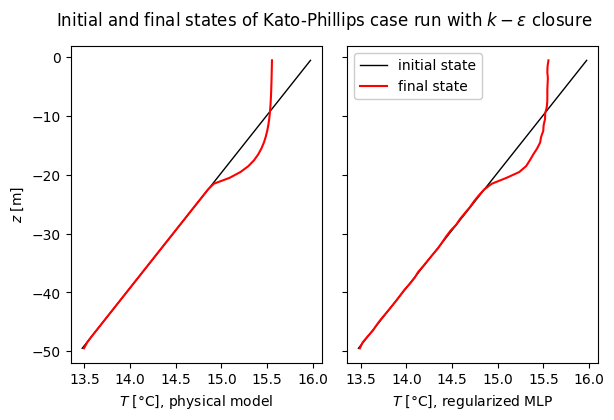

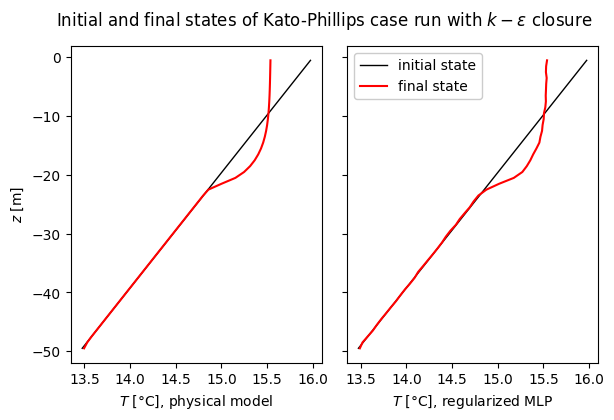

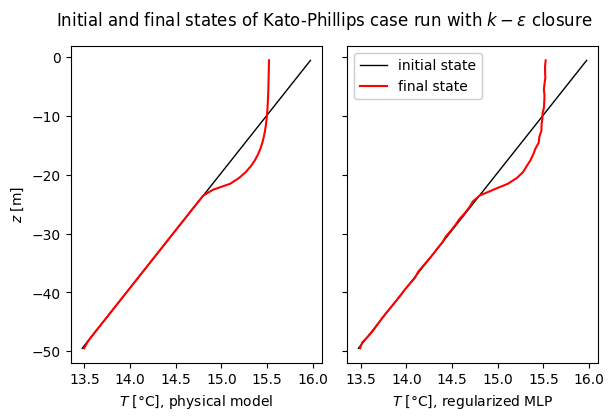

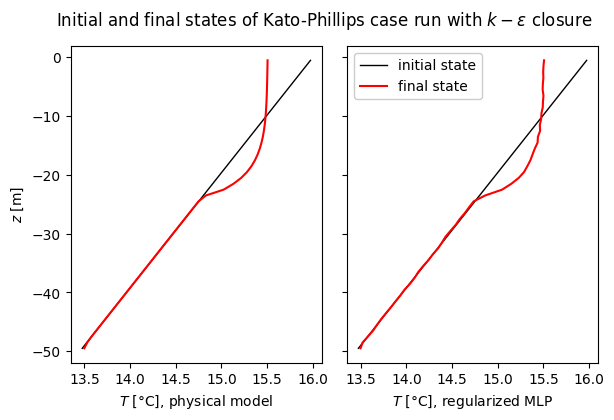

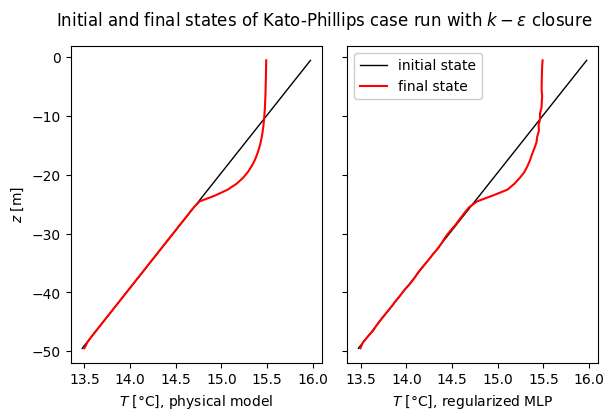

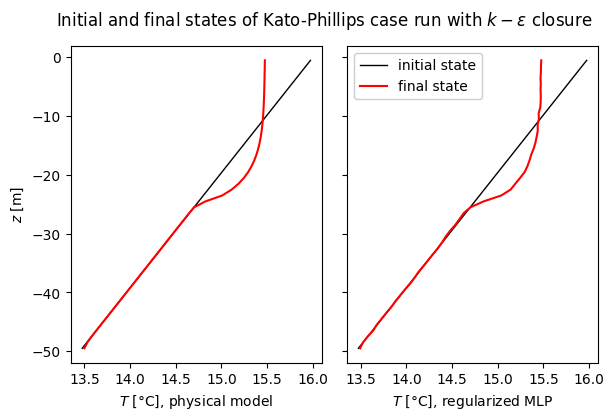

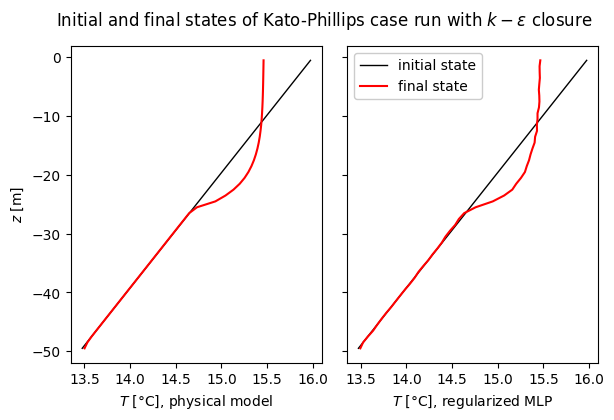

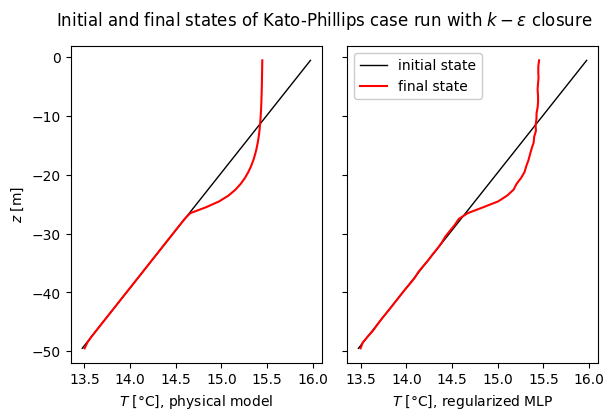

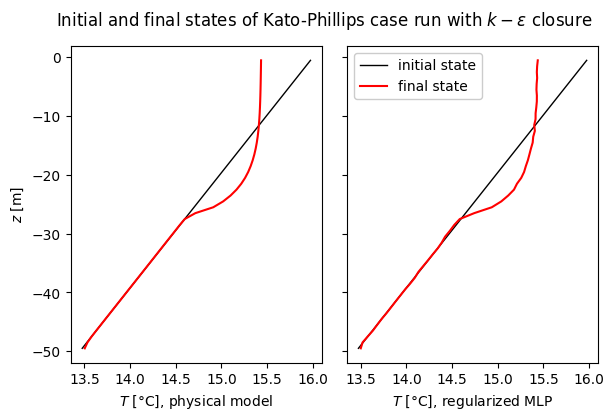

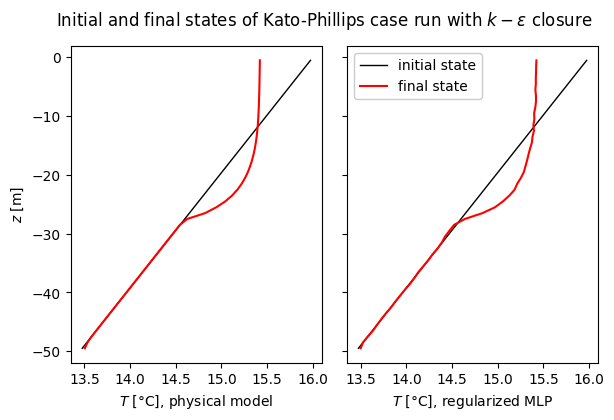

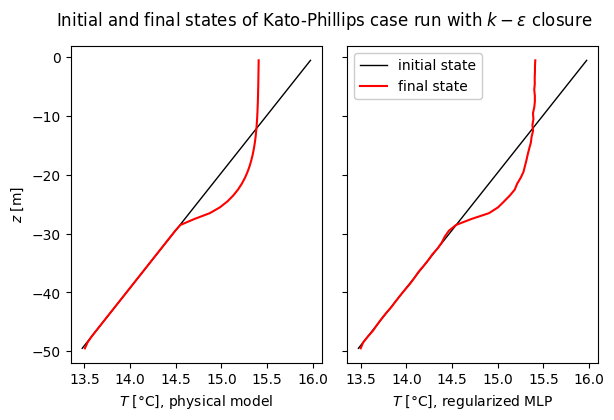

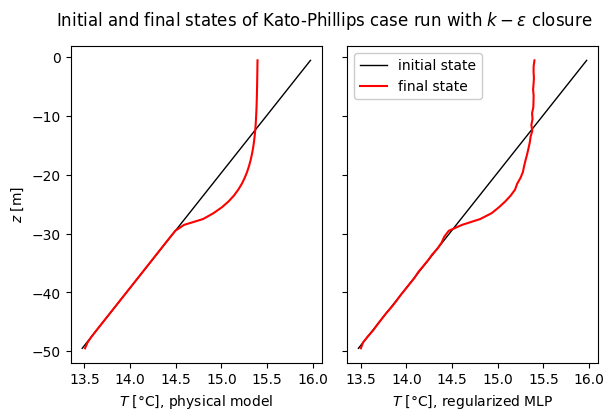

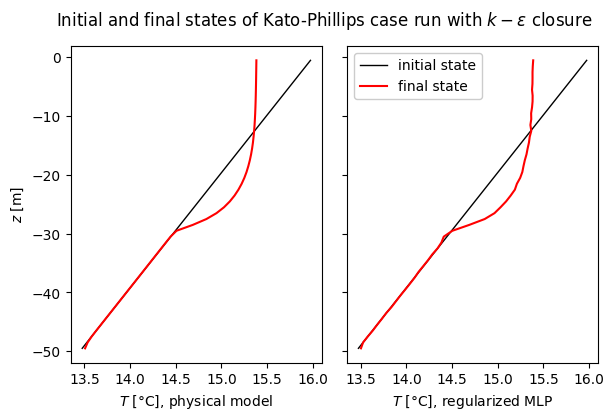

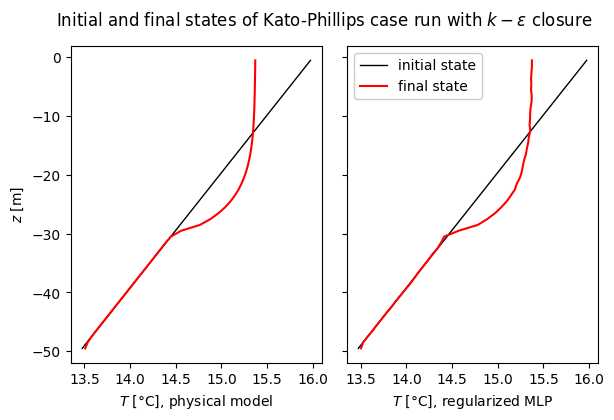

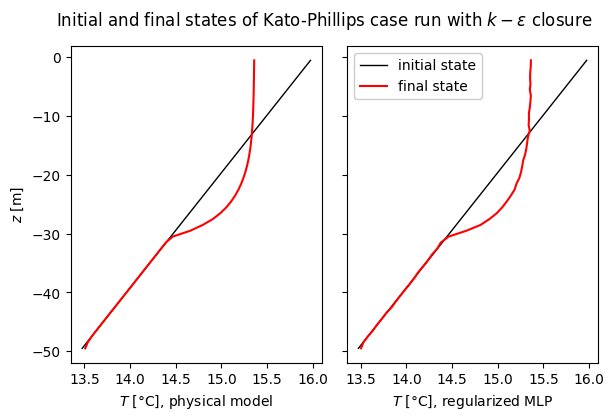

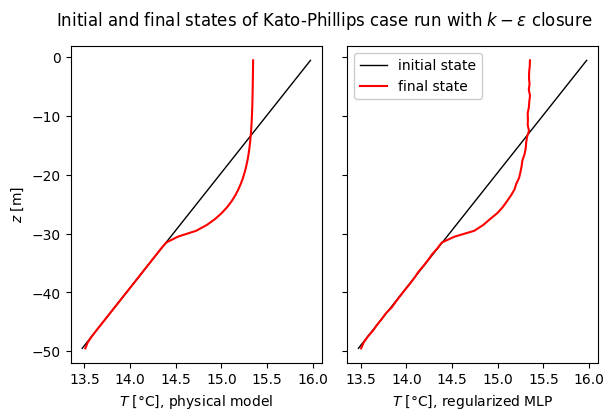

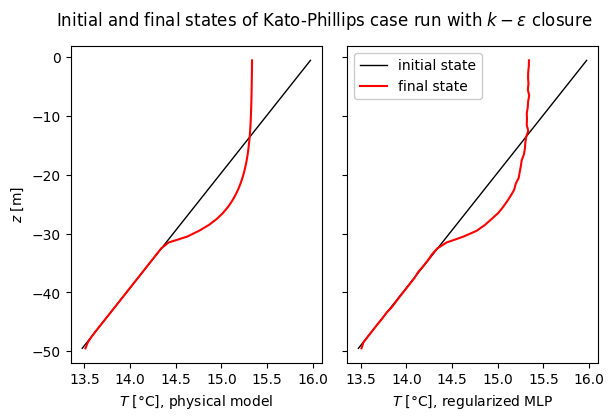

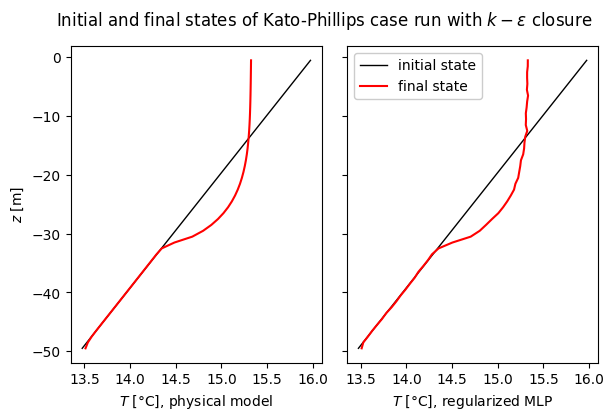

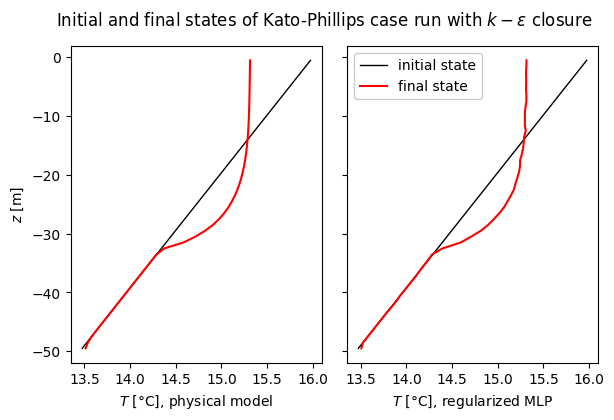

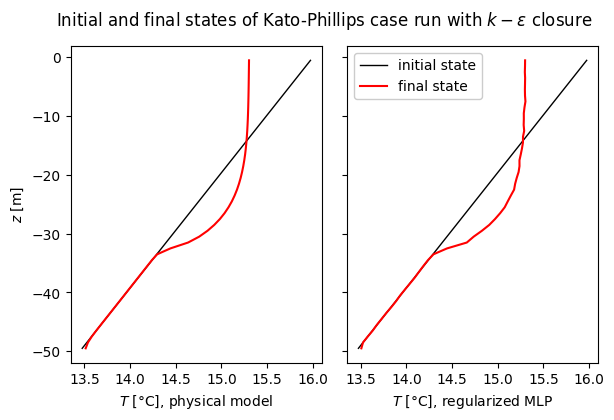

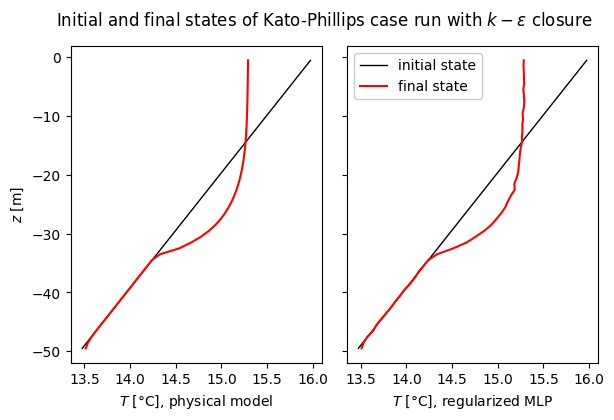

In [91]:
# Track the evolution of the trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]
n_time = 359

zr = grid.zr

#for time in range(n_time):
for time in range(n_time//10):
    
    sp: subplot_1D_type = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
    fig, [ax_t, ax_v] = sp
    fig.tight_layout(rect=[0, 0.0, 1, 0.94])
    fig.subplots_adjust(wspace=0.1)
    ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
    ax_t.plot(traj_obs.t[time*10, :], zr, 'r')
    ax_v.plot(traj_deep.t[0, :], zr, 'k', linewidth=1, label='initial state')
    ax_v.plot(traj_deep.t[time*10, :], zr, 'r', label='final state')

    ax_t.set_xlabel ('$T$ [°C], physical model')
    ax_v.set_xlabel('$T$ [°C], regularized MLP')
    ax_t.set_ylabel(r'$z$ [m]')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
    ax_v.legend(framealpha=1.)

    plt.show()